# เช็ค GPU ว่าพร้อมใช้งานไหม

In [1]:
!nvidia-smi -L 

GPU 0: GeForce GTX 1050 (UUID: GPU-75d274ed-19c4-3f8b-9300-22afa893cb08)


# Import Libary ที่ต้องใช้

In [2]:
import tensorflow as tf
import PIL
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pickle as p
import plotly
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import plotly.graph_objs as go
from tensorflow import keras
from tensorflow.keras.models import Sequential

# เช็คเวอร์ชั่น Tensorflow กำหนดให้ใช้ GPU ประมวลผล

In [3]:
import tensorflow as tf
tf.__version__
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
print( 'Tensorflow Version:', tf.__version__)
print("GPU Available::", tf.config.list_physical_devices('GPU'))

Tensorflow Version: 2.3.0
GPU Available:: []


# เตรียมข้อมูล พร้อมนับจำนวนข้อมูลที่เข้ามา 

In [4]:
import pathlib
dataset = "C:/Users/ASUS/toey_project/mask"
data_dir = pathlib.Path(dataset)

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print("image_count : ",image_count)

image_count :  10433


In [6]:
no_ware = list(data_dir.glob('no_ware/*'))

In [7]:
ware = list(data_dir.glob('ware/*'))

# กำหนดปริมาณของข้อมูล
### batch คือ ขนาดข้อมูล
### width คือ ความกว้างของรูปภาพ
### height คือ ความสูงของรูปภาพ

In [8]:
batch_size = 60
img_height = 250
img_width = 250

IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 99

NO_EPOCHS = 10

# แบ่ง Dataset มา Train 80% และ Validate 20%

In [9]:
train_ds  = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, 
  subset="training",
  seed=120,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10434 files belonging to 2 classes.
Using 8348 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=120,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10434 files belonging to 2 classes.
Using 2086 files for validation.


# แสดง Dataset มีทั้งหมด 2 class

In [11]:
class_names = train_ds.class_names
print(class_names)

['unmask', 'waremask']


# Visualize the data

# ทำการ import และแสดงรูปภาพที่อยูใน Dataset ออกมา

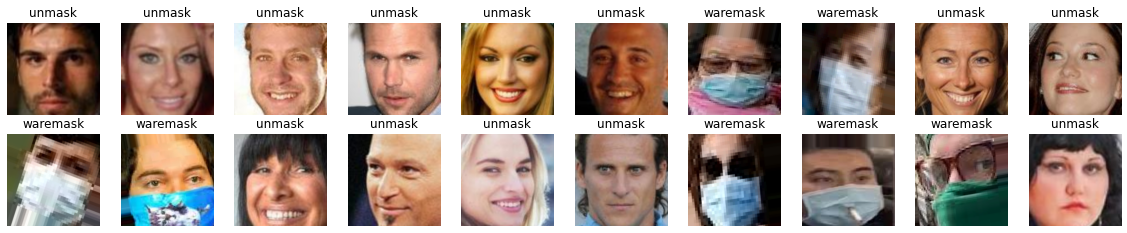

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20)) 
for images, labels in train_ds.take(1):
  for i in range(20): 
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Configure the dataset for performance

### เพื่อที่จะให้ข้อมูลเหมาะกับแนวคิด CNN ต้องเอารูปมา Normalization ก่อน

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
#ทำการ normalization แปลงค่าสี เป็น 0 1 

(60, 250, 250, 3)
(60,)


In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.06730416 0.9681177


# สร้าง Model

### กำหนด num_class = 2 เป็นจำนวนคลาสที่จะใช้แสดง ซึ่งมีค่าคือ 2 คลาส (ใส่แมส , ไม่ใส่แมส)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from matplotlib import pyplot
from tensorflow.keras.datasets import fashion_mnist

import plotly.graph_objs as go
from plotly import tools
import plotly

import cv2

# Create the model

In [18]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 250, 250, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0

# Train the model

# กำหนกค่า epoch ที่จะ Train เพื่อทำให้แม่นยำมากที่สุด

In [21]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
140/140 [==============================] - 312s 2s/step - loss: 0.2943 - accuracy: 0.8930 - val_loss: 0.0911 - val_accuracy: 0.9698
Epoch 2/30
140/140 [==============================] - 207s 1s/step - loss: 0.0987 - accuracy: 0.9672 - val_loss: 0.0943 - val_accuracy: 0.9554
Epoch 3/30
140/140 [==============================] - 206s 1s/step - loss: 0.0684 - accuracy: 0.9747 - val_loss: 0.0709 - val_accuracy: 0.9688
Epoch 4/30
140/140 [==============================] - 205s 1s/step - loss: 0.0496 - accuracy: 0.9824 - val_loss: 0.0652 - val_accuracy: 0.9765
Epoch 5/30
140/140 [==============================] - 205s 1s/step - loss: 0.0339 - accuracy: 0.9892 - val_loss: 0.0663 - val_accuracy: 0.9765
Epoch 6/30
140/140 [==============================] - 204s 1s/step - loss: 0.0220 - accuracy: 0.9923 - val_loss: 0.0670 - val_accuracy: 0.9770
Epoch 7/30
140/140 [==============================] - 204s 1s/step - loss: 0.0142 - accuracy: 0.9951 - val_loss: 0.0861 - val_accuracy: 0.9799

# Visualize training results

# Save Model

### เป็นการทำให้ เก็บรูปแบบ Model โดยที่เราไม่ต้องทำการ Train ใหม่ทุกครั้ง โดยจะใช้ Package pickle กับ model_from_json ที่มาจาก ตัว Tensorflow

In [22]:
with open('history_model_2', 'wb') as file:
    p.dump(history.history, file)
    
filepath='model1.h5'
model.save(filepath)
filepath_model = 'model1.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
    json_file.write(model_json)
    
    model.save_weights('weights_model.h5')
    print("Saved model to disk")

Saved model to disk


# Load Model

### โมเดลขึ้นมาและแสดงกราฟค่า Loss และรายละเอียดของโมเดลที่โหลดขึ้นมา

In [23]:
with open('history_model_2', 'rb') as file:
     history = p.load(file)
filepath='model1.h5'
filepath_model = 'model1.json'
filepath_weights = 'weights_model.h5'

h1 = go.Scatter(y=history['loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=history['val_loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )
                   
data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testMNIST")
predict_model = load_model(filepath) 
predict_model.summary()
with open(filepath_model, 'r') as f:
    loaded_model_json = f.read()
    predict_model = model_from_json(loaded_model_json)
    predict_model.load_weights(filepath_weights)    
    print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 250, 250, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0

# Visualize training results

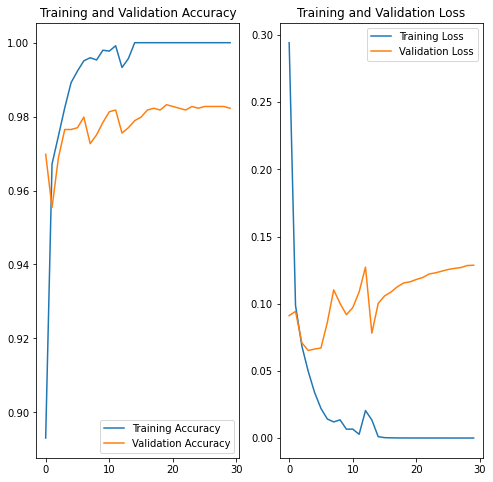

In [24]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss=history['loss']
val_loss=history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

mask tf.Tensor(1.869988e-09, shape=(), dtype=float32) 
unmask tf.Tensor(1.0, shape=(), dtype=float32)


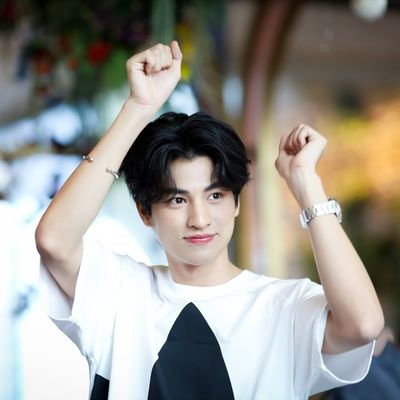

This is unmask 100.00%.


In [25]:
import requests
from IPython.display import Image
from io import BytesIO

test_path = "C:/Users/ASUS/toey_project/SodlGBs2.jpg"
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("mask",score[0],"\nunmask",score[1])
display(Image(filename=test_path,width=150, height=150))
if score[0]==np.max(score) :
    m = "mask"
elif score[1]==np.max(score) :
    m = "unmask"
print(
    "This is {} {:.2f}%."
    .format(m, 100 * np.max(score))
)

# Overfitting

# พบว่า ข้อมูลของเรามีปัญหา Overfitting ต้องใช้การทำ เทคนิค Dropout 

# Data augmentation

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

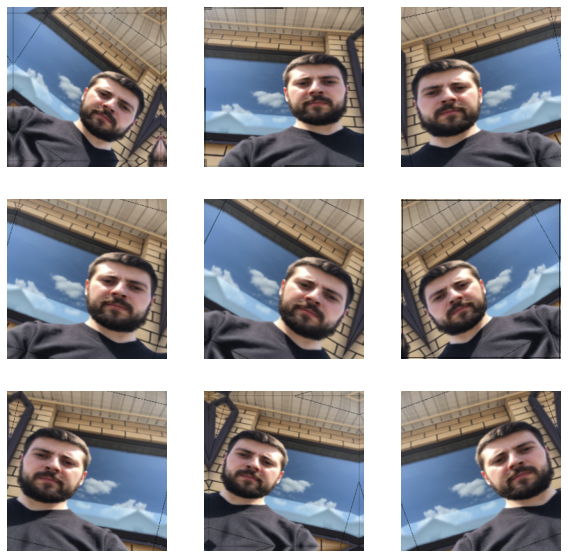

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Dropout

In [28]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile and train the model

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 250, 250, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 250, 250, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 64)       

In [31]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
140/140 [==============================] - 279s 2s/step - loss: 0.3230 - accuracy: 0.8723 - val_loss: 0.1114 - val_accuracy: 0.9645
Epoch 2/10
140/140 [==============================] - 278s 2s/step - loss: 0.1530 - accuracy: 0.9474 - val_loss: 0.1017 - val_accuracy: 0.9684
Epoch 3/10
140/140 [==============================] - 272s 2s/step - loss: 0.1211 - accuracy: 0.9571 - val_loss: 0.1217 - val_accuracy: 0.9569
Epoch 4/10
140/140 [==============================] - 277s 2s/step - loss: 0.1107 - accuracy: 0.9626 - val_loss: 0.0684 - val_accuracy: 0.9775
Epoch 5/10
140/140 [==============================] - 276s 2s/step - loss: 0.0939 - accuracy: 0.9672 - val_loss: 0.0744 - val_accuracy: 0.9722
Epoch 6/10
140/140 [==============================] - 277s 2s/step - loss: 0.0880 - accuracy: 0.9691 - val_loss: 0.0716 - val_accuracy: 0.9722
Epoch 7/10
140/140 [==============================] - 275s 2s/step - loss: 0.0846 - accuracy: 0.9710 - val_loss: 0.0667 - val_accuracy: 0.9813

# Visualize training results

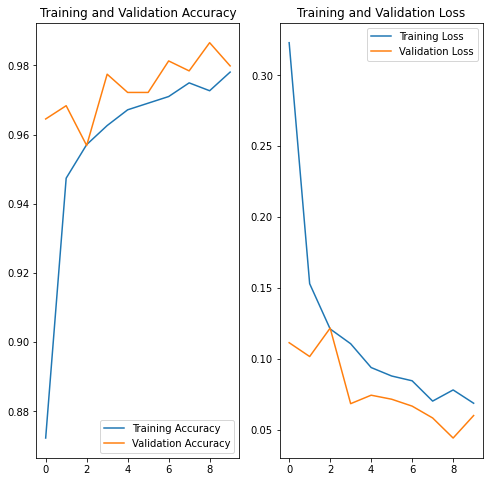

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on new data

mask tf.Tensor(0.00016582645, shape=(), dtype=float32) 
unmask tf.Tensor(0.9998342, shape=(), dtype=float32)


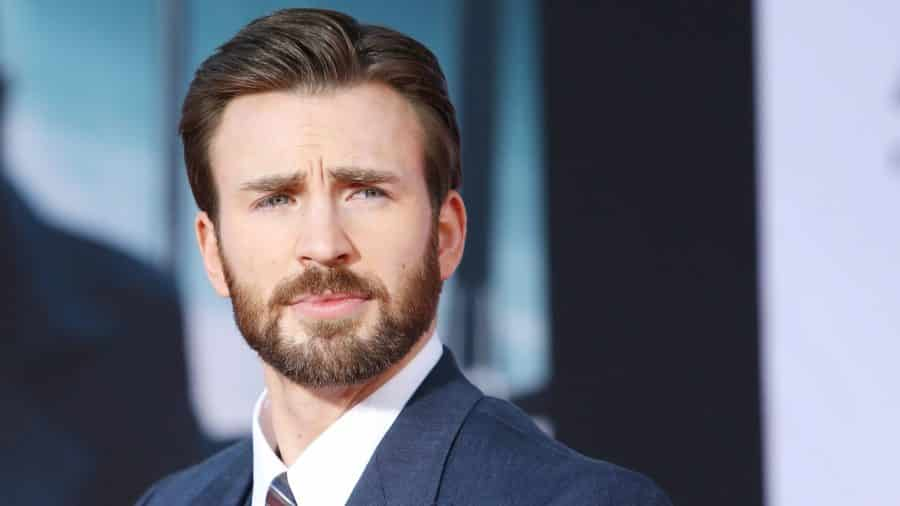

This is unmask 99.98%.


In [33]:
test_path = "C:/Users/ASUS/toey_project/190730-schager-evans-tease_i7rkbs.jpg"
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("mask",score[0],"\nunmask",score[1])
display(Image(filename=test_path,width=150, height=150))
if score[0]==np.max(score) :
    m = "mask"
elif score[1]==np.max(score) :
    m = "unmask"
print(
    "This is {} {:.2f}%."
    .format(m, 100 * np.max(score))
)

In [34]:
score = tf.nn.softmax(predictions[0])
print("Test Loss",score[0])
print("Test Accuracy:",score[1])

Test Loss tf.Tensor(0.00016582645, shape=(), dtype=float32)
Test Accuracy: tf.Tensor(0.9998342, shape=(), dtype=float32)
